O primeiro passo é importar os dados que foram disponibilizados no Kaggle (Home Credit Stability Model Competition), por isso, utilizando a API do Kaggle, importaremos apenas os dados parquet (pois são mais leves).

In [2]:
#!kaggle competitions download -c home-credit-credit-risk-model-stability -p ../data/

In [3]:
# pega o diretório pai (projeto) e adiciona ao path
import sys, os
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

import funcs.aux_utils as f_aux
import importlib
importlib.reload(f_aux)
from pathlib import Path

ZIP_PATH = Path("../data/home-credit-credit-risk-model-stability.zip")
DEST_DIR = Path("../data/parquet_files")
EXTENSION = ".parquet"

In [4]:
handler = f_aux.HandleData()
handler.unzip_files(
    zip_path = ZIP_PATH,
    extension = EXTENSION,
    dest_dir  =  DEST_DIR# opcional
)

Extraídos 32 arquivos '.parquet' em 'C:\Users\raulw\Documents\projetos\entregas\credit-risk-tec-case-pwd\data\parquet_files'


In [5]:
import pandas as pd
import numpy as np
import polars as pl


import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings

filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


pl.Config(
    **dict(
        tbl_formatting="ASCII_FULL_CONDENSED",
        tbl_hide_column_data_types=True,
        tbl_hide_dataframe_shape=True,
        fmt_float="mixed",
        tbl_cell_alignment="CENTER",
        tbl_hide_dtype_separator=True,
        tbl_cols=100,
        tbl_rows=None,
        fmt_str_lengths=100,
    )
)
os.environ["POLARS_MAX_THREADS"] = "4"

# Sobre os dados

Em decorrência da quantidade de tabelas e de colunas, será necessário a construção de um Pipeline e de uma classe auxiliar para lidar com esta quantidade massiva de dados.

O primeiro ponto da análise dos dados é verificar a distribuição da variável alvo e quantidade de missings das tabelas de treino(target). 

Por isso, primeiro verificarei a distribuição do target. Após isso realizar a separação do conjunto de validação e de teste estratificado com base na distribuição do variável alvo.

In [6]:
data = pl.read_parquet(f'{DEST_DIR}/train_base.parquet')


print(data.n_unique())
data.head()

1526659


case_id,date_decision,MONTH,WEEK_NUM,target
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


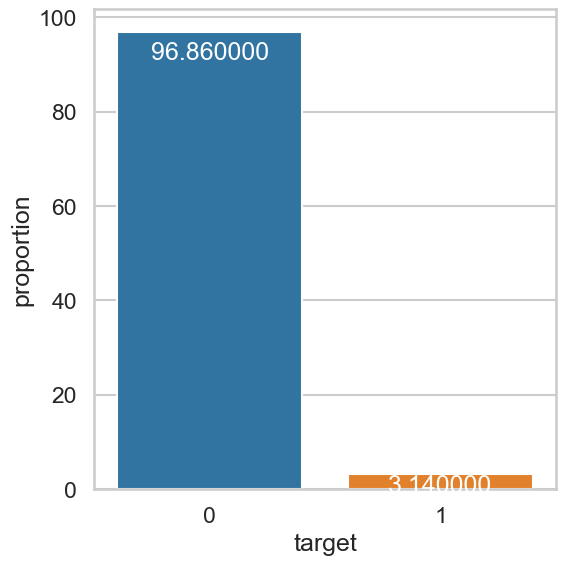

Proporção do target
Clientes não inadimplentes (em %): 96.86
Clientes não inadimplentes (em %): 3.14


In [7]:
chart_maker = f_aux.ChartMaker(figure_size=(6, 6))

count_target = data['target'].value_counts(normalize=True)
count_target = count_target.with_columns([
    (pl.col('proportion') * 100).round(2).alias('proportion')
])

chart_maker.plot_bar_chart(X=count_target['target'], y=count_target['proportion'])

print('Proporção do target')
print(f'Clientes não inadimplentes (em %): {count_target['proportion'][0]}')
print(f'Clientes não inadimplentes (em %): {count_target['proportion'][1]}')

del chart_maker

Podemos ver que a classe alvo é bastante desbalanceada, tendo cerca de apenas 3,1% dos clientes inadimplementes. Denota-se então a necessidade da aplicação e cuidado de técnicas de modo a não enviesar o modelo e causar um overfit a respeito do conjunto de treinamento. Dessa forma, para garantir que o processo de EDA e de criação do modelo esteja seguro de vazamento de dados, separaremos o conjunto de dados em: 

    1. Treino
    2. Validação
    3. Teste

Utilizaremos a função train_test_split do scikit-learn com o parâmetro "stratify" aplicado em virtude do desbalanceamento do target.

In [8]:
from sklearn.model_selection import train_test_split

X = data.drop(['target', 'WEEK_NUM', 'MONTH'])
y = data['target']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.25, random_state=42)

print(f'Shape do conjunto de variáveis preditoras de treinamento: {X_train.shape} | proporção: {X_train.shape[0] / data.shape[0] * 100:.2f}')
print(f'Shape do conjunto de variáveis preditoras de validação: {X_val.shape} | proporção: {X_val.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape do conjunto de variáveis preditoras de teste: {X_test.shape} | proporção: {X_test.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de treinamento: {y_train.shape} | proporção: {y_train.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de validação: {y_val.shape} | proporção: {y_val.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de test: {y_test.shape} | proporção: {y_test.shape[0] / data.shape[0] * 100:.2f} ')

train = X_train.with_columns(y_train)
val = X_val.with_columns(y_val)
test = X_test.with_columns(y_test)

Shape do conjunto de variáveis preditoras de treinamento: (915995, 2) | proporção: 60.00
Shape do conjunto de variáveis preditoras de validação: (305332, 2) | proporção: 20.00 
Shape do conjunto de variáveis preditoras de teste: (305332, 2) | proporção: 20.00 
Shape da variável alvo de treinamento: (915995,) | proporção: 60.00 
Shape da variável alvo de validação: (305332,) | proporção: 20.00 
Shape da variável alvo de test: (305332,) | proporção: 20.00 


In [9]:
train_ids = train['case_id'].to_list()
val_ids   = val['case_id'].to_list()
test_ids  = test['case_id'].to_list()

Separados em seus respectivos conjuntos, vamos avaliar quantos valores missing o conjunto de treino possui. Além disso, vamos verificar as tabelas que temos e quais seus respectivos shapes e quantidade de missings também.

Outro ponto importante é que várias tabelas compartilham a mesma estrutura (provavelmente foram apenas particionadas para organização). Para simplificar o pipeline de pré-processamento, utilizaremos a classe DataCatalog (em aux_utils.py) para concatenar automaticamente essas partições com base em regras de nome (prefixos/sufixos), garantindo que todas as features repetidas apareçam apenas uma vez e permitindo um tratamento uniforme das colunas.

In [10]:
def filter_tables_by_ids(tables, ids):
    return {
        name: df.filter(pl.col("case_id").is_in(ids))
        for name, df in tables.items()
    }

In [11]:
missings = train.null_count()

missings

case_id,date_decision,target
0,0,0


In [17]:
# concatene cada grupo em seu próprio DataFrame
base_prefixes = [
    "train_credit_bureau_a_1",
    "train_credit_bureau_a_2",
    "train_static_0",
    "train_applprev_1",
]

optimized_train = f_aux.HandleData.load_and_optimize_all(DEST_DIR, train_ids)
optimized_val   = f_aux.HandleData.load_and_optimize_all(DEST_DIR, val_ids)
optimized_test  = f_aux.HandleData.load_and_optimize_all(DEST_DIR, test_ids)

# 3) Concatene cada grupo via concatenate_files(dict, prefix)
concatenated = {
    pref: f_aux.HandleData.concatenate_files(
        source=optimized_train,
        prefix=pref
    )
    for pref in base_prefixes
}


In [18]:
used_stems = {
    stem
    for pref in base_prefixes
    for stem in optimized_train
    if stem.startswith(pref)
}

other_stems = [stem for stem in optimized_train if stem not in used_stems]

all_train_tables = {}
all_train_tables.update(concatenated)
all_train_tables.update({stem: optimized_train[stem] for stem in other_stems})

In [19]:
def report_missing(df: pl.DataFrame) -> dict[str,int]:
    return {
        col: cnt
        for col, cnt in df.null_count().to_dicts()[0].items()
        if cnt > 0
    }

for name, df in all_train_tables.items():
    print(f"\n===== {name} =====")
    print(df.shape)
    display(df.head(3))


===== train_credit_bureau_a_1 =====
(9566645, 79)


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,numberofcontrsvalue_358L,numberofinstls_229L,numberofinstls_320L,numberofoutstandinstls_520L,numberofoutstandinstls_59L,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
388,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",null,null,135806.0,"""2020-08-06""",null,null,"""2018-08-06""",null,null,null,"""a55475b1""",0.0,null,null,8.0,2018.0,null,"""a55475b1""","""P204_66_73""",8742.799805,null,null,"""2019-01-11""",null,8742.799805,null,null,null,1,null,null,null,null,null,null,0.0,null,null,null,0.0,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,8.0,2018.0,null,null,null,null,null,"""60c73645""","""a55475b1""",null,null,114325.804688,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
388,null,null,"""4408ff0f""","""a55475b1""","""7241344e""","""a55475b1""",null,null,null,"""2023-06-20""",null,null,"""2018-06-20""",null,374419.5,0.0,"""a55475b1""",0.0,null,null,7.0,2018.0,null,"""a55475b1""","""55b002a9""",null,null,null,"""2019-01-24""",null,7811.446289,null,null,null,0,2.0,1.0,null,60.0,null,54.0,0.0,null,null,null,0.0,null,null,260093.703125,null,0.0,0.0,null,null,null,0.0,null,null,7.0,2018.0,null,null,30.0,null,null,"""96a8fdfe""","""a55475b1""",null,null,null,"""ab3c25cf""","""ab3c25cf""",null,268897.625,0.0,0.0,374419.5,0.0
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""2019-01-28""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null



===== train_credit_bureau_a_2 =====
(113111704, 19)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
388,"""8fd95e4b""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""
388,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",1,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""



===== train_static_0 =====
(915995, 168)


case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,…,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
0,null,null,1917.599976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0,30000.0,"""CAL""",0.0,0.0,null,null,null,null,0.0,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,null,"""OTHER""","""OTHER""",null,null,null,null,null,null,24.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""",null,null
1,null,null,3134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0,19999.800781,"""CAL""",0.0,0.0,null,null,null,null,0.0,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,null,"""OTHER""","""OTHER""",null,null,null,null,null,null,18.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""",null,null
2,null,null,4937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,78000.0,"""CAL""",0.0,0.0,null,null,null,null,0.0,…,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,36.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""","""AL""",null



===== train_applprev_1 =====
(3914993, 41)


case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
2,0.0,640.200012,null,null,"""a55475b1""",0.0,"""2013-04-03""",null,0.0,null,null,null,null,10000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""","""2010-02-15""","""SINGLE""","""2013-05-04""","""CASH""",false,null,8200.0,null,0,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",24.0
2,0.0,1682.400024,null,null,"""a55475b1""",0.0,"""2013-04-03""",null,0.0,null,null,null,null,16000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""","""2010-02-15""","""SINGLE""","""2013-05-04""","""CASH""",false,null,8200.0,null,1,null,12.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",12.0
3,0.0,6140.0,null,null,"""P94_109_143""",null,"""2019-01-07""",null,0.0,null,null,null,null,59999.800781,"""CAL""",null,null,"""P131_33_167""",0.0,null,null,"""P97_36_170""","""2018-05-15""","""MARRIED""","""2019-02-07""","""CASH""",false,null,11000.0,null,0,null,12.0,"""a55475b1""","""a55475b1""","""P94_109_143""","""a55475b1""",null,"""D""",12.0



===== train_applprev_2 =====
(8442581, 6)


case_id,cacccardblochreas_147M,conts_type_509L,credacc_cards_status_52L,num_group1,num_group2
2,null,"""PRIMARY_MOBILE""",null,0,0
2,null,"""EMPLOYMENT_PHONE""",null,0,1
2,null,"""PRIMARY_MOBILE""",null,1,0



===== train_base =====
(915995, 5)


case_id,date_decision,MONTH,WEEK_NUM,target
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0



===== train_credit_bureau_b_1 =====
(51509, 45)


case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_228A,credlmt_3940954A,credor_3940957M,credquantity_1099L,credquantity_984L,debtpastduevalue_732A,debtvalue_227A,dpd_550P,dpd_733P,dpdmax_851P,dpdmaxdatemonth_804T,dpdmaxdateyear_742T,installmentamount_644A,installmentamount_833A,instlamount_892A,interesteffectiverate_369L,interestrateyearly_538L,lastupdate_260D,maxdebtpduevalodued_3940955A,num_group1,numberofinstls_810L,overdueamountmax_950A,overdueamountmaxdatemonth_494T,overdueamountmaxdateyear_432T,periodicityofpmts_997L,periodicityofpmts_997M,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_1093A,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
467,78000.0,"""ea6782cc""","""2016-10-25""","""2019-10-25""","""7241344e""","""4257cbed""",null,null,null,"""c5a72b57""",null,null,0.0,26571.96875,null,null,0.0,11.0,2016.0,null,null,2898.76001,null,null,"""2019-01-10""",0.0,2,36.0,0.0,11.0,2016.0,null,"""a0b598e4""",0.0,"""e914c86c""",10.0,"""96a8fdfe""",null,null,null,"""a55475b1""","""a55475b1""",null,null
467,null,"""ea6782cc""","""2011-06-15""","""2031-06-13""","""7241344e""","""724be82a""",3e6,10000.0,3e6,"""P164_34_168""",2.0,1.0,null,null,0.0,0.0,null,null,null,0.0,0.0,null,null,null,"""2019-01-20""",null,0,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",0.0,0.0,null,"""fa4f56f1""","""ab3c25cf""",3e6,10000.0
467,null,"""ea6782cc""","""2019-01-04""","""2021-08-04""","""7241344e""","""724be82a""",null,null,130365.0,"""P164_34_168""",1.0,2.0,null,null,0.0,0.0,null,null,null,0.0,26571.96875,null,null,null,"""2019-01-20""",null,1,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",null,null,null,"""ab3c25cf""","""ab3c25cf""",78000.0,960000.0



===== train_credit_bureau_b_2 =====
(770498, 6)


case_id,num_group1,num_group2,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
467,0,0,"""2018-11-15""",null,null
467,0,1,"""2018-12-15""",null,null
467,1,0,"""2018-12-15""",null,null



===== train_debitcard_1 =====
(94499, 6)


case_id,last180dayaveragebalance_704A,last180dayturnover_1134A,last30dayturnover_651A,num_group1,openingdate_857D
331,null,null,null,0,"""2015-03-19"""
390,null,null,null,0,"""2014-07-23"""
390,null,null,null,1,"""2015-10-01"""



===== train_deposit_1 =====
(87110, 5)


case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D
331,260.373993,"""2018-03-18""",0,"""2015-03-19"""
390,203.602005,"""2017-09-30""",1,"""2015-10-01"""
390,223.680008,null,2,"""2016-06-08"""



===== train_other_1 =====
(30746, 7)


case_id,amtdebitincoming_4809443A,amtdebitoutgoing_4809440A,amtdepositbalance_4809441A,amtdepositincoming_4809444A,amtdepositoutgoing_4809442A,num_group1
43801,12466.600586,12291.200195,914.200012,0.0,304.800018,0
43991,3333.400146,3273.400146,0.0,0.0,0.0,0
44130,63.799999,60.799999,0.0,0.0,0.0,0



===== train_person_1 =====
(1784148, 37)


case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,num_group1,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
0,"""1986-07-01""",null,null,"""P88_18_84""",false,false,"""P167_100_165""","""P97_36_170""","""2017-09-15""","""MORE_FIVE""","""OTHER""","""P142_57_166""","""P167_100_165""","""MARRIED""",null,null,null,"""SALARIED_GOVT""",null,"""P10_39_147""",10800.0,null,0,0.0,1.0,1.0,"""P88_18_84""","""P167_100_165""",null,null,null,"""CL""",null,true,"""F""","""PRIMARY_MOBILE"""
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,1,1.0,1.0,4.0,"""a55475b1""","""a55475b1""","""SPOUSE""",null,false,"""EM""",null,null,null,"""PHONE"""
0,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,2,2.0,4.0,5.0,"""a55475b1""","""a55475b1""","""COLLEAGUE""","""SPOUSE""",false,"""PE""",null,null,null,"""PHONE"""



===== train_person_2 =====
(985471, 11)


case_id,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,num_group1,num_group2,relatedpersons_role_762T
6,"""P55_110_32""","""CONTACT""","""P10_68_40""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""",0,0,null
6,"""P55_110_32""","""PERMANENT""","""P10_68_40""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,1,null
6,"""P204_92_178""","""CONTACT""","""P65_136_169""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""",1,0,"""OTHER_RELATIVE"""



===== train_static_cb_0 =====
(900348, 53)


case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
357,null,null,null,"""1988-04-01""",null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,6.0,6301.399902,null,"""2019-01-25""",null,null,null,null,null,null
388,null,null,null,"""1989-04-01""",null,"""1989-04-01""",null,6.0,8.0,2.0,10.0,4.0,"""a55475b1""","""a55475b1""","""a55475b1""",2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6.0,"""a55475b1""","""a55475b1""",10.0,null,null,null,null,null,null,6.0,14548.0,null,"""2019-01-28""",null,null,null,null,3.0,5.0
405,null,null,null,"""1974-03-01""",null,"""1974-03-01""",null,0.0,0.0,0.0,1.0,0.0,"""a55475b1""","""a55475b1""","""a55475b1""",0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.0,"""a55475b1""","""a55475b1""",1.0,null,null,null,null,null,null,6.0,10498.240234,null,"""2019-01-21""",null,null,null,null,2.0,0.0



===== train_tax_registry_a_1 =====
(1968114, 5)


case_id,amount_4527230A,name_4527232M,num_group1,recorddate_4527225D
28631,711.0,"""f980a1ea""",3,"""2019-09-13"""
28631,1946.0,"""f980a1ea""",2,"""2019-09-13"""
28631,2600.0,"""f980a1ea""",1,"""2019-09-13"""



===== train_tax_registry_b_1 =====
(665083, 5)


case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1
49435,6885.0,"""2019-10-16""","""6b730375""",0
49435,6885.0,"""2019-10-16""","""6b730375""",1
49435,6885.0,"""2019-10-16""","""6b730375""",2



===== train_tax_registry_c_1 =====
(2004412, 5)


case_id,employername_160M,num_group1,pmtamount_36A,processingdate_168D
357,"""c91b12ff""",0,1200.0,"""2019-01-04"""
357,"""c91b12ff""",1,1200.0,"""2018-11-28"""
357,"""c91b12ff""",2,972.799988,"""2018-11-01"""


In [20]:
records = []
for name, df in optimized_train.items():
    n_rows, n_cols = df.shape
    total_cells = n_rows * n_cols


    nulls_melted = (
        df
        .null_count()          # DataFrame: cada coluna tem count de nulls
        .melt()                # DataFrame com col | value
    )

    total_missing = int(
        nulls_melted
        .select(pl.col("value").sum())  # DataFrame com uma única célula
        .item()                          # extrai o número puro
    )

    null_ratio = round(total_missing / total_cells * 100, 2) if total_cells else 0.0

    records.append({
        "table":       name,
        "total_cells": total_cells,
        "null_count":  total_missing,
        "null_ratio":  null_ratio,
    })


summary = (
    pl.DataFrame(records)
      .sort("null_ratio", descending=True)
)
display(summary)

qtd = summary.filter(pl.col("null_ratio") > 30).height
print(f"Tabelas com > 30% de missings: {qtd}")

table,total_cells,null_count,null_ratio
"""train_credit_bureau_a_1_0""",194546348,146266044,75.18
"""train_credit_bureau_a_1_1""",284743887,184999060,64.97
"""train_credit_bureau_a_1_2""",177946631,112570395,63.26
"""train_static_cb_0""",47718444,29629873,62.09
"""train_credit_bureau_a_1_3""",98528089,61082052,61.99
…,…,…,…
"""train_base""",4579975,0,0.0
"""train_other_1""",215222,0,0.0
"""train_tax_registry_a_1""",9840570,0,0.0
"""train_tax_registry_b_1""",3325415,0,0.0


Tabelas com > 30% de missings: 21


Mesmo que o dataset principal não apresente valores faltantes, é fundamental que, na fase de pré-processamento, adotemos uma estratégia de imputação para o caso de surgirem gaps em futuras bases ou durante junções. Observamos também que cerca de mais da metade das tabelas auxiliares possui mais de 30 % de valores faltantes, um volume bastante elevado. Para mitigar isso, removeremos automaticamente qualquer coluna que apresente mais de 80 % de dados ausentes e, nas demais, aplicaremos técnicas de imputação adequadas a cada tipo de variável (média/mediana para numéricas, moda ou “missing” explícito para categóricas etc.).

A seguida, vamos definir como trataremos as demais tabelas do dataset. Portanto, para que o processo de leitura e EDA da tabela seja bem sucedido e de maneira eficaz, iremos aplicar algumas transformações nos dados. Para isso, seguiremos algumas premissas:

- Tabelas com depth > 1 (que representam medidas retiradas dos dados estáticos) serão agregadas (utilizando "case_id") a partir de alguns critérios, são eles:

    - Disclaimer: As colunas das tabelas com profundidade possuem identificadores em seus nomes, indicando qual tipo de transformações foram aplicadas nestas tabelas, são elas:
        1. **P** (Days over due - Dias em atraso): Medidas que envolvem datas de atrasos, proporções de datas e etc.
        2. **M** (Masking categorias - Categorias com máscaras): Categorias como genêro, status e outros dados categóricos
        3. **A** (Tranform Ammount - Transformações de quantidade): Quantidades numéricas que foram transformadas ou processadas seguindo alguma lógica
        4. **D** (Transform Date - Transformações de datas): Colunas que dizem a respeito sobre datas que foram adicionadas como informações relevantes 
        5. **T** e **L** (Unespecified Transform - Transformações não inespecificadas): Valores que não se encaixam em nenhuma das outras categorias e não possuem "tracking" de informações, entretanto, podem sinalizar informações relevantes ao modelo.

    - **Para colunas terminadas em P e A (dados numéricos)**: Será aplicado um casting de tipo e agregações por -> Valor máximo, último valor e média
    - **Para colunas terminadas em D**: Será aplicado casting para date e agregações por -> Valor máximo, última data e média
    - **Para colunas terminadas em M (Strings)**: Será aplicado um casting para "category" e posteriormente agregadas por -> Valor máximo (lexicograficamente o último) e o último valor
    - **Para outras colunas**: Definiremos agregações por -> Máximo e último valor 

Portanto para estes processos ocorrerem de forma harmoniosa e automatizada utilizaremos as classes definidas no pacote funcs.aux_utils.py com o intuito de aplicar tais transformações e ao final juntar todas as tabelas baseado no "case_id".

In [31]:
import importlib
import funcs.aux_utils as f_aux
importlib.reload(f_aux)

<module 'funcs.aux_utils' from 'c:\\Users\\raulw\\Documents\\projetos\\entregas\\credit-risk-tec-case-pwd\\funcs\\aux_utils.py'>

In [32]:
# depois de carregar e agregar...
aggregated = f_aux.Aggregator.aggregate_depth_tables(
    tables     = optimized_train,
    static_key = "train_base"
)

# 3) Una com a sua tabela base
df_train = f_aux.Aggregator.merge_all(
    tables     = optimized_train,
    aggregated = aggregated,
    static_key = "train_base"
)


TypeError: ExprStringNameSpace.strptime() got an unexpected keyword argument 'fmt'